In [7]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime
import pandas as pd 
import cartopy.crs as ccrs
mpl.style.use("ccic.mplstyle")

# Timeseries of all datasets 

In [10]:
def get_global_mean(data, latname, lonname):
    weights = np.cos(np.deg2rad(data[latname]))
    weights.name = "weights"
    weighted_data = data.weighted(weights)
    global_mean = weighted_data.mean((lonname, latname))
    return global_mean

In [9]:
# read in all datasets 
data_path = Path('/scratch/ccic_record/data/processed/') 

#ERA5 
era5_tiwp= xr.open_dataarray(data_path / 'era5_tiwp_global_mean_timeseries.nc')
era5_ca= xr.open_dataarray(data_path / 'era5_ca_global_mean_timeseries.nc')

# ISCCP
isccp = xr.open_dataset(data_path / 'isccp_tiwp_ca.nc')
isccp_ca = isccp.ca_avg_masked
isccp_tiwp = isccp.tiwp_avg_masked

# CCIC
ccic = xr.open_dataset(data_path / 'ccic_gridsat.nc')
ccic_tiwp = ccic.tiwp_mean_masked
ccic_ca = ccic.ca_mean_masked
start = datetime.datetime(1980, 1, 1, 0, 0)
end = datetime.datetime(2022, 12, 31, 0, 23)
ccic_times = pd.date_range(start, end, freq= '1ME')
# get CCIC coordinates 
ds = xr.open_dataset('/scratch/ccic_record/data/ccic/gridsat/ccic_gridsat_199911_monthlymean.nc') 
# assign coordinates 
coords = {'latitude': ds.latitude.values, 'longitude': ds.longitude.values}
ccic = ccic.assign_coords(coords)

# PATMOS-X
patmosx = xr.open_dataset(data_path / 'PATMOS-x_timeseries198108-201912_notebook_results.nc')
patmosx_tiwp = patmosx.tiwp_typeIaverage_masked
patmosx_ca = patmosx.cloud_probability_typeIaverage_masked

# MODIS 
modis = xr.open_dataset(data_path / 'modis_cf_tiwp_time_series.nc')
modis_tiwp = modis.TIWP_global_mean_masked
modis_ca = modis.CF_global_mean_masked
modis_times = modis.date

# CloudSat 
cloudsat = xr.open_dataset('/scratch/ccic_record/data/cloudsat/cloudsat_monthly_mean_timeseries.nc') 
dardar_timeseries = cloudsat.iwp_dardar
twocice_timeseries = cloudsat.iwp_2cice
cloudsat_times = cloudsat.time

# CPCIR 
cpcir = xr.open_dataset('/scratch/ccic_record/data/ccic/cpcir/ccic_cpcir_1998-2023_monthlymeans.nc')
cpcir_timeseries = cpcir.tiwp_mean 
cpcir_times = cpcir.time

In [15]:
### get annual means ### 
era5_annual = era5_tiwp.resample(time="YE").mean() 
patmosx_annual = patmosx_tiwp.resample(time="YE").mean() 
isccp_annual = isccp_tiwp.resample(time="YE").mean() 
modis_annual = modis_tiwp.resample(date="YE").mean() 

# CCIC 
start = datetime.datetime(1980, 1, 1, 0, 0)
end = datetime.datetime(2022, 12, 31, 0, 23)
ccic_times = pd.date_range(start, end, freq= '1ME')
coords = {'time': ccic_times}
ccic_annual = xr.DataArray(ccic_tiwp, coords = coords).resample(time="YE").mean() 

## Apply land sea mask 

In [90]:
path = Path('/scratch/ccic_record/data/') 
ds= xr.open_dataset(path / 'ERA5'/ 'era5_tcsw_tciw_tcc_1980_2023.nc') 
era5 = ds.tcsw[:,0,:,:] + ds.tciw[:,0,:,:]
ccic = xr.open_dataarray(path / 'ccic' / 'gridsat' / 'ccic_gridsat_tiwp_annualmeans.nc')

# ERA5 mask 
mask = xr.open_dataset(path / 'mask_24.nc')
mask = mask.mask.astype(int)
interpolated_mask = mask.interp(coords = {'longitude': era5.longitude.values, 'latitude': era5.latitude.values}, method = 'linear') 

lsm = xr.open_dataset('lsm_1279l4_0.1x0.1.grb_v4_unpack.nc').lsm.squeeze()
lsm_era = lsm.interp(coords = {'longitude': era5.longitude.values, 'latitude': era5.latitude.values}, method = 'linear')
lsm_ccic = lsm.interp(coords = {'longitude': era5.longitude.values, 'latitude': era5.latitude.values}, method = 'linear')

era_land = get_global_mean(era5.where(lsm_era > 0.7), 'latitude', 'longitude') 
era_ocean = get_global_mean(era5.where(lsm_era < 0.5), 'latitude', 'longitude' ) 
# divide into tropics and midlatitudes
era_land_tropics = get_global_mean(era5.where( (lsm_era > 0.7)  & (era5.latitude > -30)  & (era5.latitude < 30)  ), 'latitude', 'longitude') 
era_ocean_tropics = get_global_mean(era5.where((lsm_era <0.5 )  & (era5.latitude > -30)  & (era5.latitude < 30) ), 'latitude', 'longitude' ) 
era_land_midlats = get_global_mean(era5.where( (lsm_era > 0.7)  & (era5.latitude < -30)  | (era5.latitude > 30) ), 'latitude', 'longitude') 
era_ocean_midlats = get_global_mean(era5.where( (lsm_era < 0.5)  & (era5.latitude < -30)  | (era5.latitude > 30) ), 'latitude', 'longitude') 

ccic_land = get_global_mean(ccic.where(lsm_ccic > 0.7), 'latitude', 'longitude') 
ccic_ocean = get_global_mean(ccic.where(lsm_ccic < 0.5), 'latitude', 'longitude') 

## Global means of Cloud amount and ice water path 

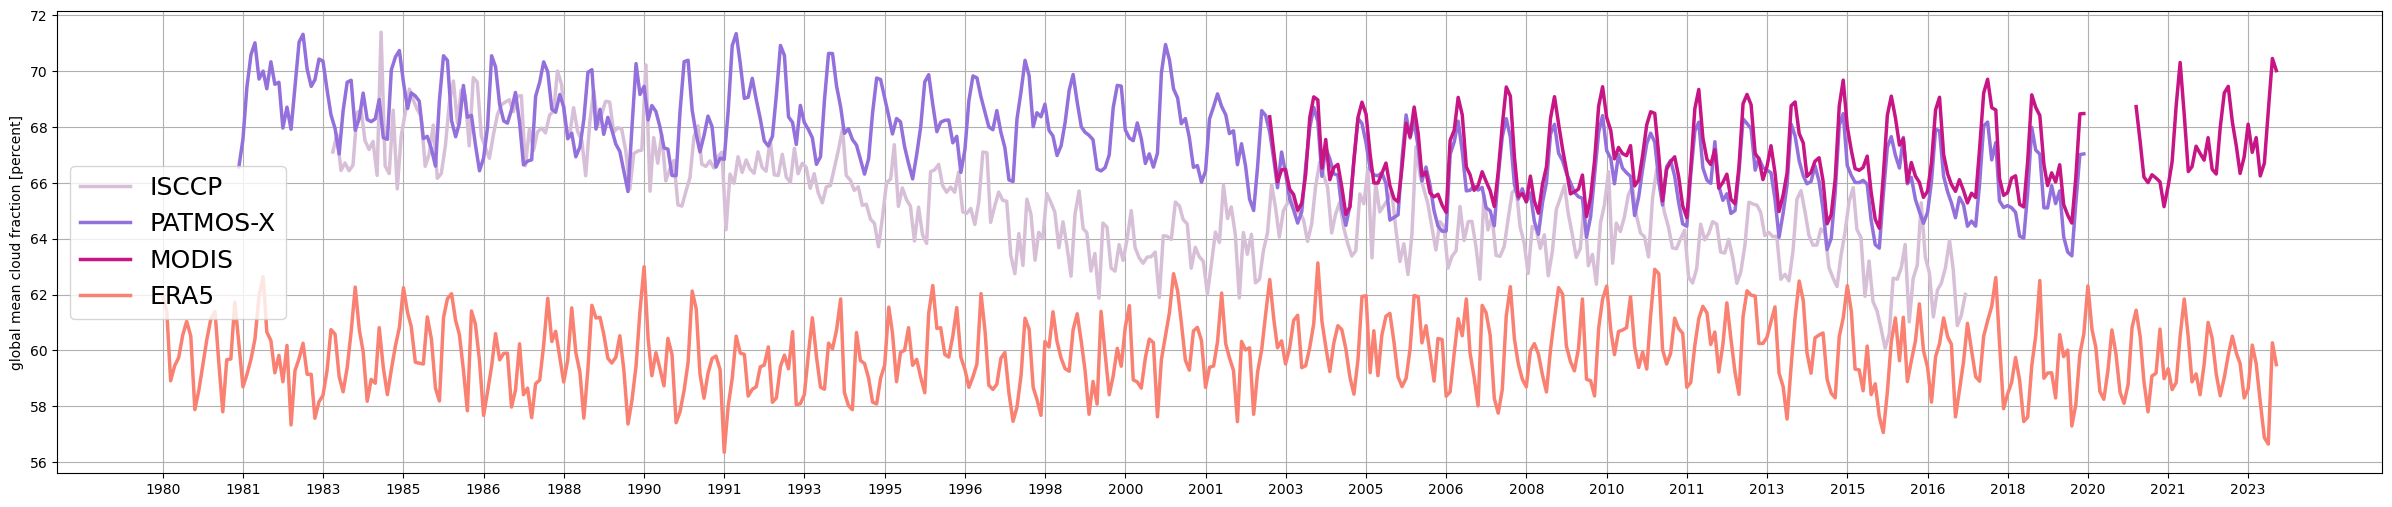

In [12]:
plt.figure(figsize=(30,6))

lw = 2.5

# monthly timeseries cloud amount 
plt.subplot(1,1,1)
plt.plot(isccp_ca.time, isccp_ca.data, label = 'ISCCP', lw = lw, color = 'thistle')
plt.plot(patmosx_ca.time, patmosx_ca.data* 100, label = 'PATMOS-X', lw = lw, color = 'mediumpurple') 
plt.plot(modis_times, modis_ca* 100, lw = lw ,label = 'MODIS' , color = 'mediumvioletred')
plt.plot(era5_ca.time, era5_ca.data* 100 , label = 'ERA5', lw = lw, color = 'salmon')

plt.ylabel(r'global mean cloud fraction [percent]')
plt.xticks(era5_ca.time[::20], era5_ca.time.dt.year.values[::20])
plt.grid()
plt.legend(fontsize = 18)
plt.savefig('global_mean_cloud_fraction_timeseries.png', bbox_inches = 'tight')
plt.show()

# Global means of ice water path 

In [17]:
# add trends of annual means 
from scipy.stats import linregress

slope_era, intercept_era, r_era, p_era, se = linregress(range(len(era5_annual.time)), era5_annual.data)
slope_ccic, intercept_ccic, r_ccic, p_ccic, se = linregress(range(len(ccic_annual.time)), ccic_annual.data)
slope_modis, intercept_modis, r_modis, p_modis, se = linregress(range(len(modis_annual.date)), modis_annual.data[~np.isnan(modis_annual.data)] / 1000)
slope_isccp, intercept_isccp, r_isccp, p_isccp, se = linregress(range(len(isccp_annual.time)), isccp_annual.data)
slope_patmosx, intercept_patmosx, r_patmosx, p_patmosx, se = linregress(range(len(patmosx_annual.time)), patmosx_annual.data/ 1000)

print(slope_ccic, slope_modis, slope_isccp, slope_patmosx, slope_era)

0.00018798600858664166 8.864802567765433e-05 0.000195620262256446 0.0006007847615879421 0.00021328043121742143


In [18]:
# significance test 
print(p_ccic, p_modis, p_isccp, p_patmosx, p_era)

1.709703132652224e-05 0.00022201650414570748 0.006215428759210686 4.8014419981540963e-11 2.476879493613104e-19


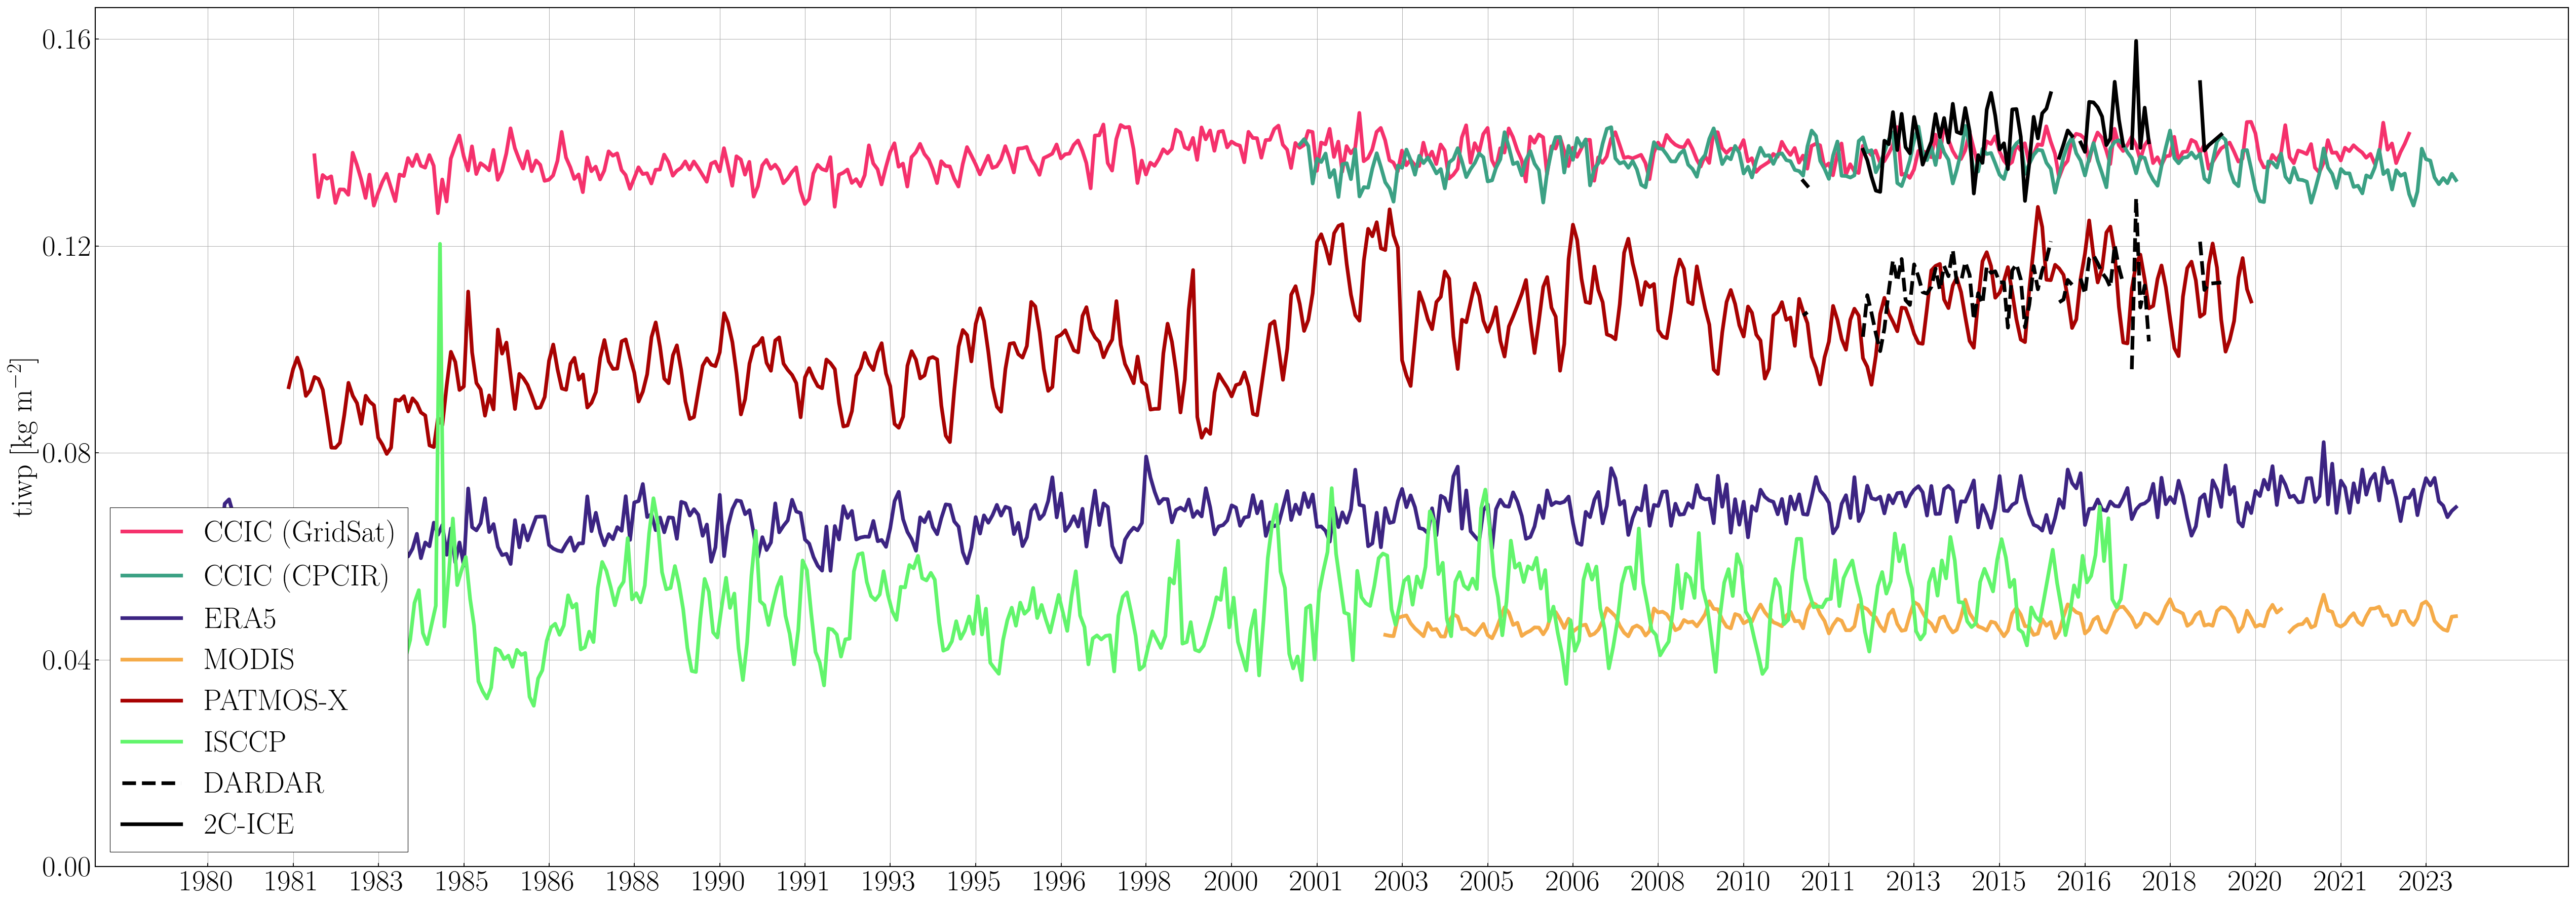

In [11]:
plt.figure(figsize=(34,12))

fs = 28
lw = 3.5
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times[24:], ccic_tiwp.data[24:], label = 'CCIC (GridSat)', lw = lw)
plt.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CCIC (CPCIR)')
plt.plot(era5_tiwp.time, era5_tiwp.data, label = 'ERA5',  lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = 'MODIS',lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = 'PATMOS-X' , lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP',  lw = lw) 


# add CloudSat and CPCIR 
plt.plot(cloudsat.time, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR',  color = 'k',linestyle ='--')
plt.plot(cloudsat.time, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = 'k')

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs, loc = 'lower left')

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries_ccicstyle.png', bbox_inches = 'tight')
plt.show()

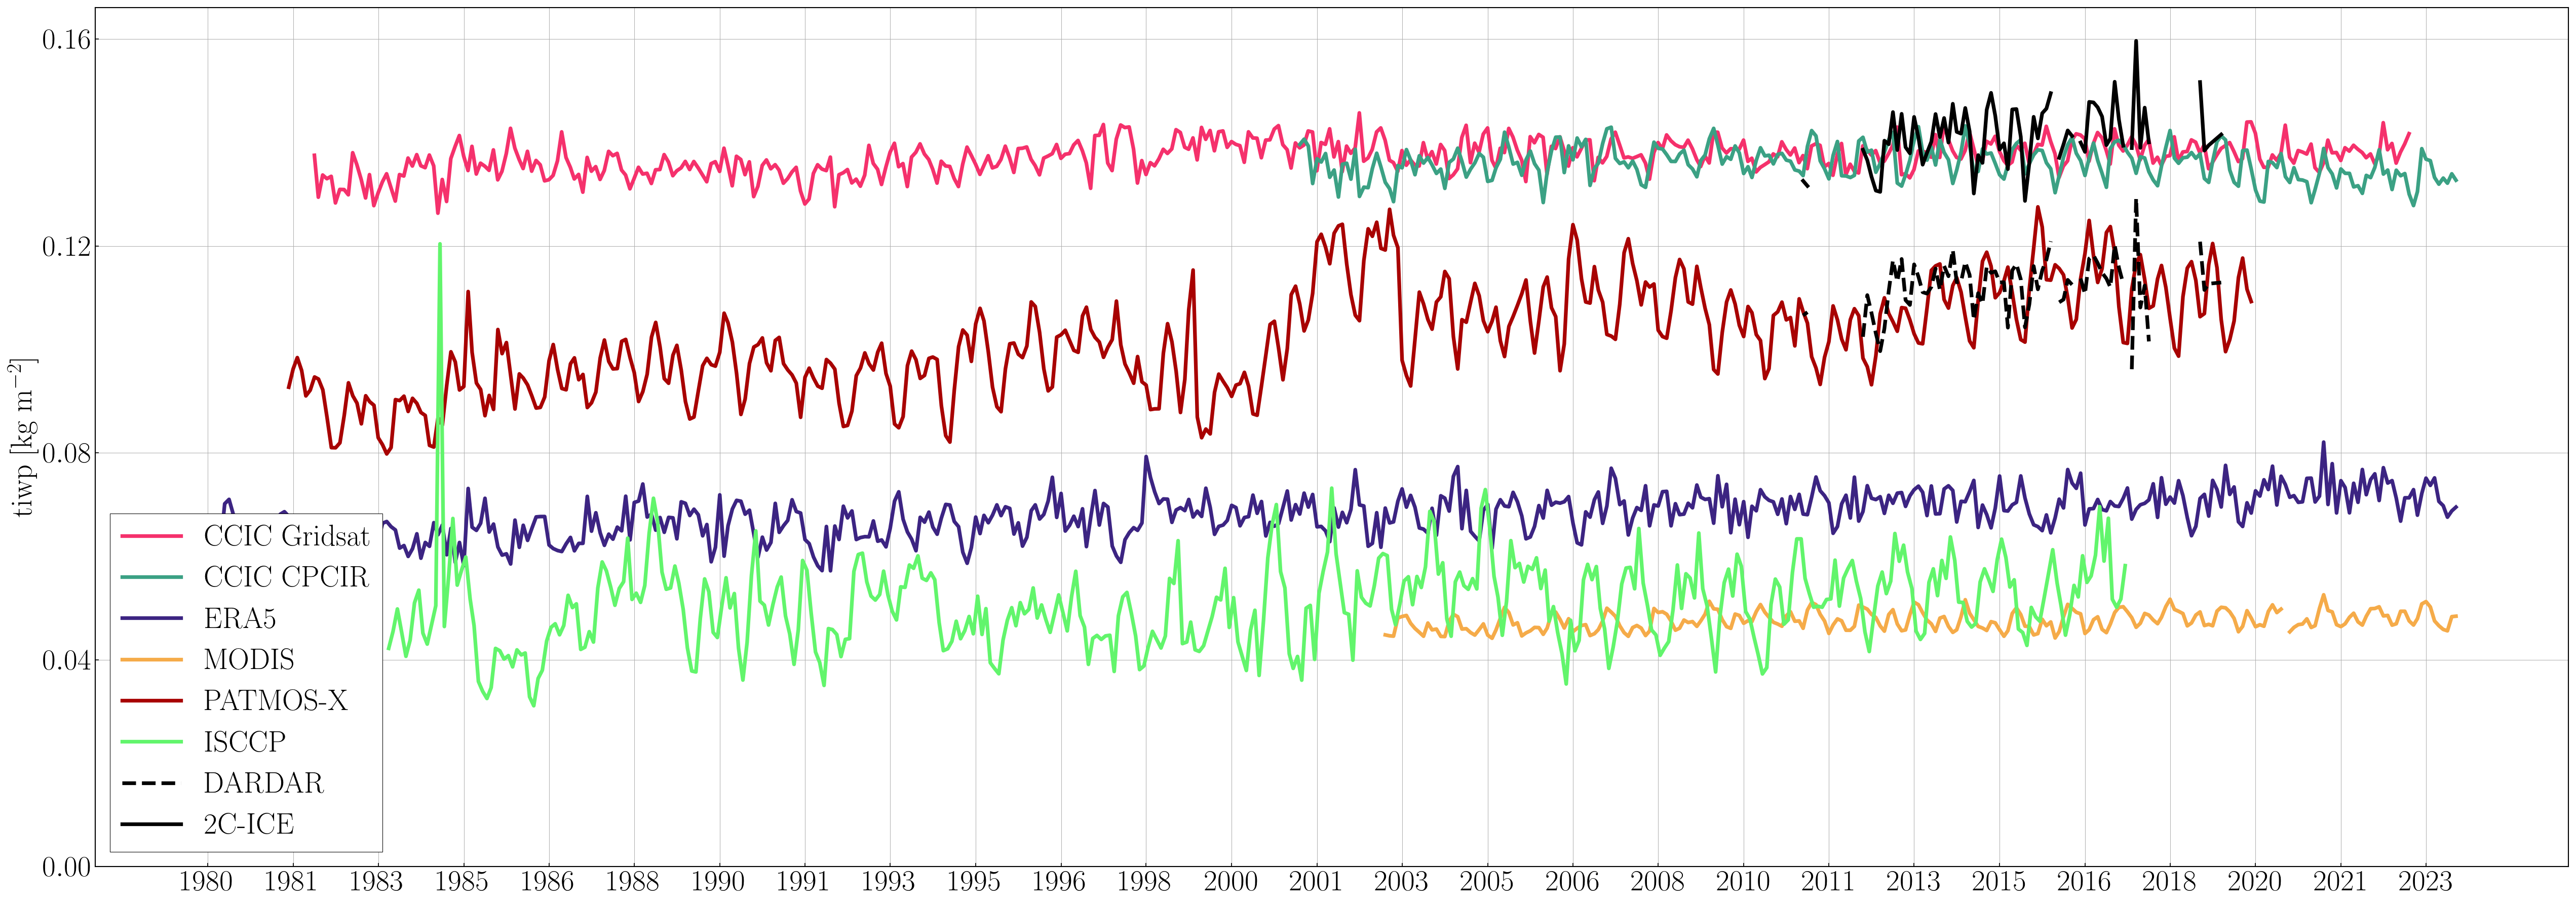

In [8]:
plt.figure(figsize=(34,12))

fs = 28
lw = 3.5
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times[24:], ccic_tiwp.data[24:], label = 'CCIC (GridSat)', lw = lw)
plt.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CCIC (CPCIR)')
plt.plot(era5_tiwp.time, era5_tiwp.data, label = 'ERA5',  lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = 'MODIS',lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = 'PATMOS-X' , lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP',  lw = lw) 


# add CloudSat and CPCIR 
plt.plot(cloudsat.time, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR',  color = 'k',linestyle ='--')
plt.plot(cloudsat.time, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = 'k')

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs, loc = 'lower left')

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries_ccicstyle.png', bbox_inches = 'tight')
plt.show()

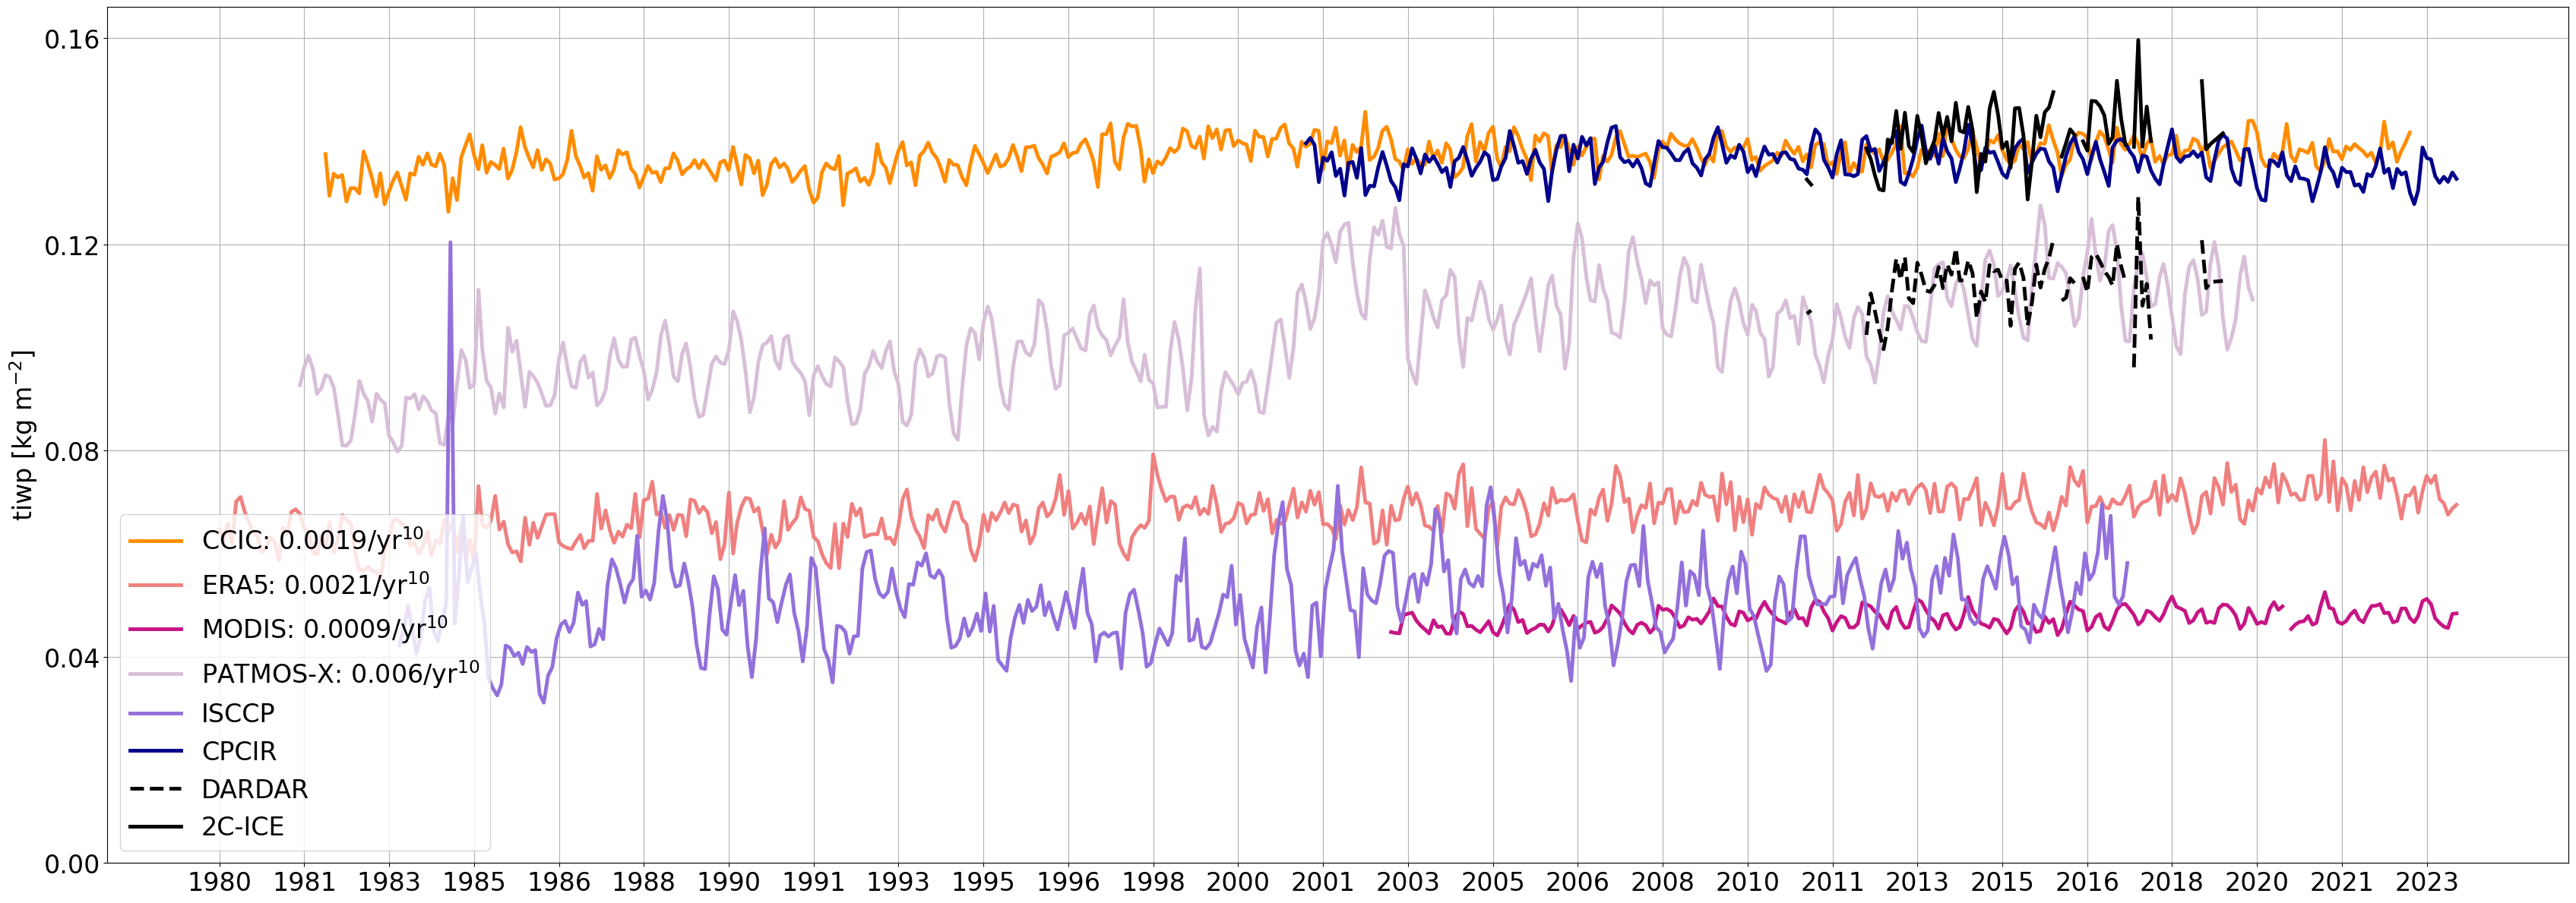

In [35]:
plt.figure(figsize=(34,12))

fs = 24
lw = 3.5
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times[24:], ccic_tiwp.data[24:], label = ('CCIC: ' + str(np.round(slope_ccic*10, decimals = 4)) + '/yr$^{10}$'), color = 'darkorange', lw = lw)
plt.plot(era5_tiwp.time, era5_tiwp.data, label = ('ERA5: ' + str(np.round(slope_era*10, decimals = 4))+  '/yr$^{10}$'), color = 'lightcoral', lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = ('MODIS: ' + str(np.round(slope_modis*10, decimals = 4))+  '/yr$^{10}$'), color = 'mediumvioletred', lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = ('PATMOS-X: ' + str(np.round(slope_patmosx*10, decimals = 4)) +  '/yr$^{10}$') , color = 'thistle', lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP', color = 'mediumpurple', lw = lw) 
plt.plot(cpcir.time[24:], cpcir_timeseries[24:], lw = lw, label= 'CPCIR', color = 'darkblue')

# add CloudSat and CPCIR 
plt.plot(cloudsat.time, dardar_timeseries.where(dardar_timeseries > 0   ), lw =lw, label = 'DARDAR', color= 'k', linestyle ='--')
plt.plot(cloudsat.time, twocice_timeseries.where(twocice_timeseries > 0  ), lw = lw, label = '2C-ICE', color = 'k')

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs, loc = 'lower left')

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries.png', bbox_inches = 'tight')
plt.show()

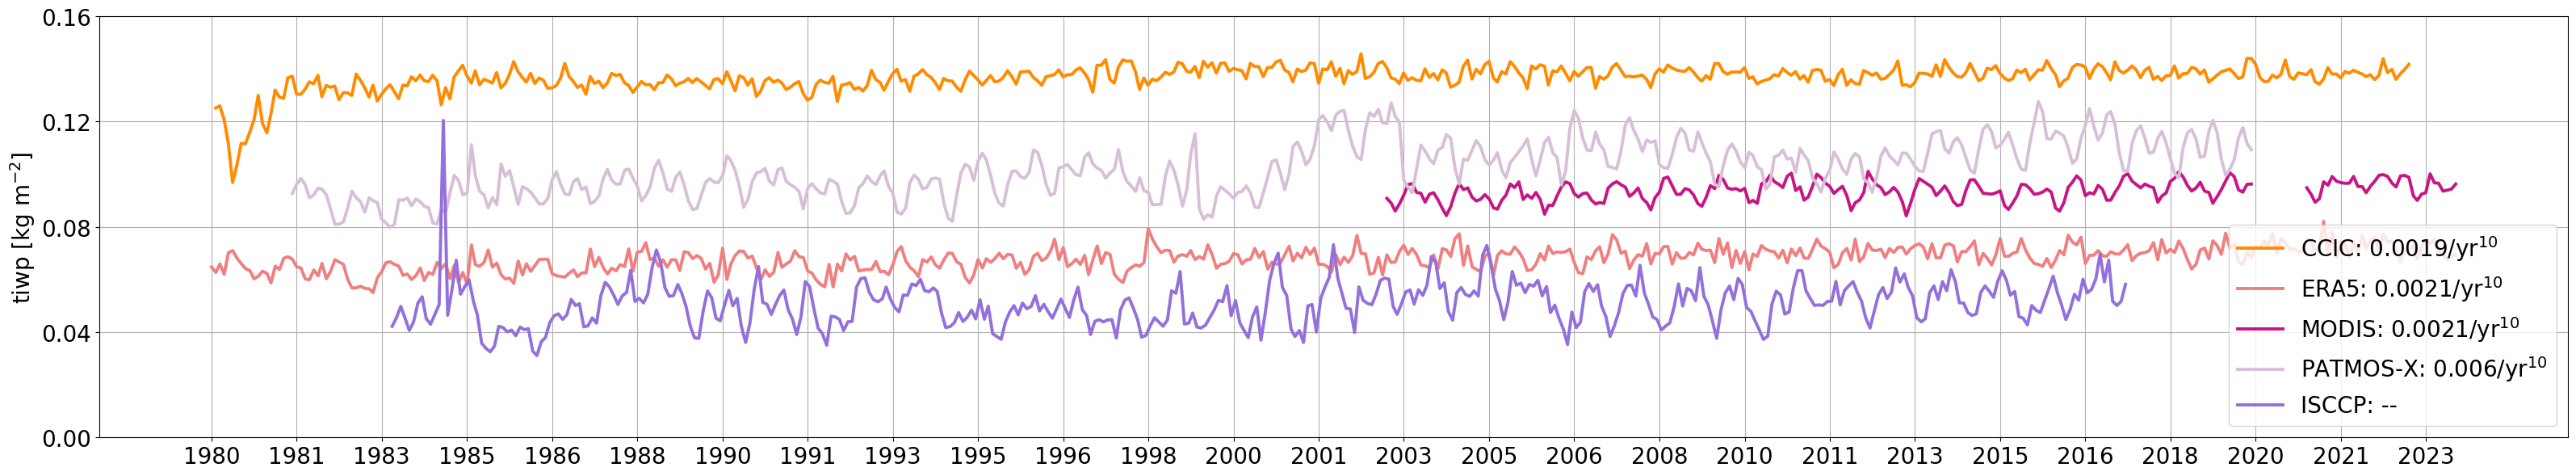

In [16]:
plt.figure(figsize=(32,6))

fs = 20
lw = 2.8
# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(ccic_times, ccic_tiwp.data, label = ('CCIC: ' + str(np.round(slope_ccic*10, decimals = 4)) + '/yr$^{10}$'), color = 'darkorange', lw = lw)
plt.plot(era5_tiwp.time, era5_tiwp.data, label = ('ERA5: ' + str(np.round(slope_era*10, decimals = 4))+  '/yr$^{10}$'), color = 'lightcoral', lw = lw)
plt.plot(modis_times, modis_tiwp/1000, label = ('MODIS: ' + str(np.round(slope_modis*10, decimals = 4))+  '/yr$^{10}$'), color = 'mediumvioletred', lw = lw)
plt.plot(patmosx_tiwp.time, patmosx_tiwp.data/1000, label = ('PATMOS-X: ' + str(np.round(slope_patmosx*10, decimals = 4)) +  '/yr$^{10}$') , color = 'thistle', lw = lw)
plt.plot(isccp_tiwp.time, isccp_tiwp.data, label = 'ISCCP: --', color = 'mediumpurple', lw = lw) 

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.18, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs)

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/tiwp_timeseries.png', bbox_inches = 'tight')
plt.show()

## Split up by ocean vs. land 

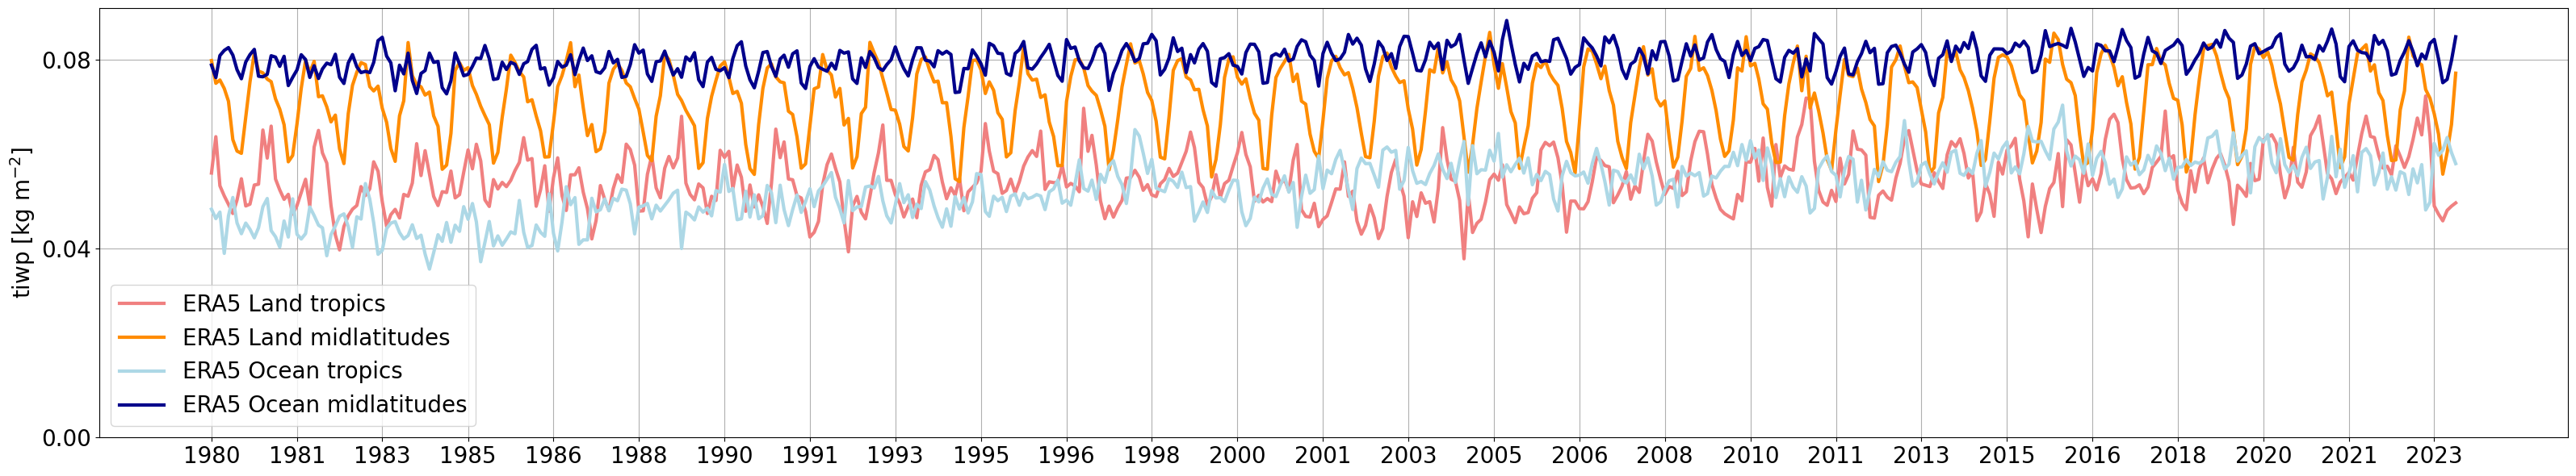

In [92]:
plt.figure(figsize=(32,6))

fs = 20
lw = 3.0 

# monthly timeseries ice water path 
plt.subplot(1,1,1)
plt.plot(era5.time, era_land_tropics, label = 'ERA5 Land tropics', color = 'lightcoral', lw = lw)
plt.plot(era5.time, era_land_midlats, label = 'ERA5 Land midlatitudes', color = 'darkorange', lw = lw)
plt.plot(era5.time, era_ocean_tropics, label = 'ERA5 Ocean tropics', color = 'lightblue', lw = lw)
plt.plot(era5.time, era_ocean_midlats, label = 'ERA5 Ocean midlatitudes', color = 'darkblue', lw = lw) 

plt.ylabel(r'tiwp [kg m$^{-2}]$', fontsize = fs)
plt.xticks(era5_tiwp.time[::20], era5_tiwp.time.dt.year.values[::20], fontsize = fs)
plt.yticks(np.arange(0., 0.12, 0.04), fontsize = fs)
plt.grid()
plt.legend(fontsize= fs)

plt.tight_layout()
plt.savefig('/scratch/ccic_record/data/plots/ERA5_timeseries_land_ocean.png', bbox_inches = 'tight')
plt.show()

## Difference cloud fraction [in %] ISCCP - CCIC 

In [4]:
# interpolate CCIC to ISCCP grid 
ccic_isccp_grid = ccic.ca.interp(coords = {'longitude': isccp.longitude.values, 'latitude': isccp.latitude.values}, method = 'linear')
ccic_timmean = ccic_isccp_grid * 100 
isccp_timmean = isccp.ca
diff= isccp_timmean - ccic_timmean 

In [5]:
import seaborn as sns 
cmap_sns= sns.color_palette("vlag", as_cmap=True)

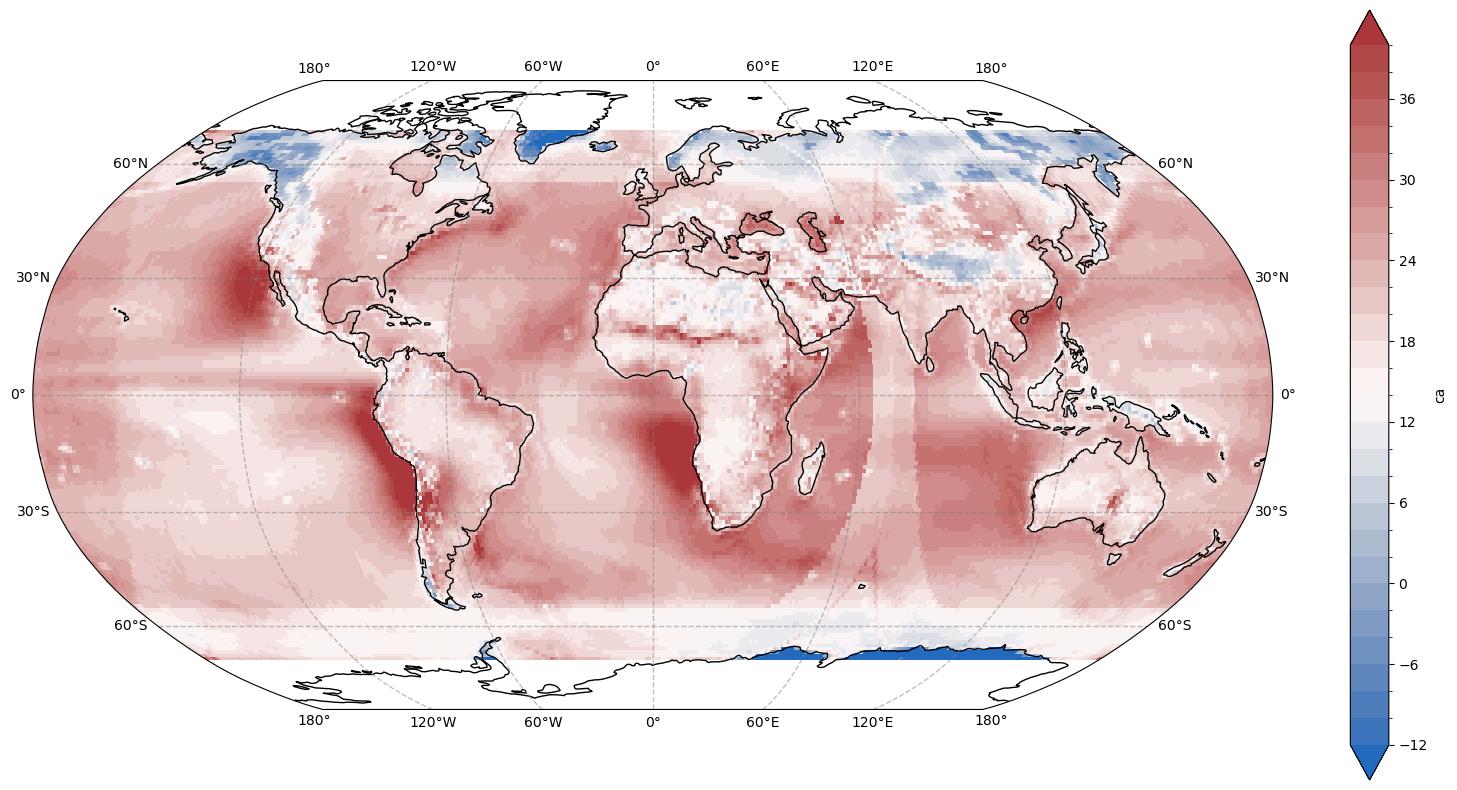

In [6]:
plt.figure(figsize=(20,10))

ax = plt.axes(projection=ccrs.Robinson())
diff.plot(
    ax=ax, 
    levels = np.arange(-12,42, 2),
    transform=ccrs.PlateCarree(),
    colors=cmap_sns)

ax.coastlines(
    resolution='110m') 
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  linewidth=1,
                  color='gray',
                  alpha=0.5,
                  linestyle='--')

plt.savefig('diff_map_isscp_minus_ccic.png', bbox_inches = 'tight')